## 1. 扩散模型（Diffusion Model）

In [124]:
from IPython.display import Image, display
url = 'https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png'
display(Image(url=url, width=600))

分两个方向：

**正向过程（扩散过程）**：将原始数据（如图像）逐步添加高斯噪声，最终转化为纯噪声。每一步的噪声强度由预设的调度策略控制（如线性增加噪声）。这一过程是确定性的，不需要学习。

**逆向过程（去噪过程）**：模型通过训练学习如何逐步去除噪声，将纯噪声还原为原始数据。这是扩散模型的核心：通过神经网络（如U-Net）预测每一步的噪声，并迭代去噪。

## 2. 数学表达式

### 2.1 正向过程

将数据 $x_0$ 逐步添加高斯噪声，在T步之后，变为纯噪声 $x_T\sim\mathcal{N}(0,I)$  

假设从真实分布中取样 $x_0$ 服从某个分布 $x_0 \sim q(x)$  

$t$ 时刻的分布只取决于前一时刻 $t-1$ 的状态（马尔可夫性）  

$\beta_t$ 是 $t$ 时刻加入的噪声比例，预设的噪声调度参数（例如线性增长或余弦调度）    

$q(x_t|x_{t-1})=\mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_tI))$  

通过重参数化技巧，可以从 $x_0$ 直接计算任意 $t$ 时刻的 $x_t=\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon,  \epsilon\sim\mathcal{N}(0,I)$

推导过程：  

$$x_t = \sqrt{1-\beta_t} x_{t-1} + \sqrt\beta_t\epsilon_{t-1} $$
$$=\sqrt{1-\beta_t}(\sqrt{1-\beta_{t-1}} x_{t-2} + \sqrt{\beta_{t-1}}\epsilon_{t-2})+ \sqrt\beta_t\epsilon_{t-1}$$
$$=\sqrt{1-\beta_t}\sqrt{1-\beta_{t-1}} x_{t-2} + \sqrt{1-\beta_t}\sqrt{\beta_{t-1}}\epsilon_{t-2}+ \sqrt\beta_t\epsilon_{t-1}=\cdots$$
$$=\prod_{i=1}^t\sqrt{1-\beta_i}x_0 + \sqrt\beta_t\epsilon_{t-1} + \sqrt{1-\beta_t}\sqrt{\beta_{t-1}}\epsilon_{t-2} + \cdots $$

除第一项外，剩余项为n个标准正态分布的叠加，方差
$$\sigma^2=\beta_t+(1-\beta_t)\beta_{t-1}+\cdots$$
令$$\alpha_t=1-\beta_t$$
有
$$\sigma^2=1-\alpha_t+\alpha_t(1-\alpha_{t-1})+\cdots$$
$$=1-\prod_{i=1}^t\alpha_i$$ 
于是
$$x_t=\left(\prod_{i=1}^t(1-\beta_i) \right)^{1/2}x_0+\left(1-\prod_{i=1}^t(1-\beta_i)\right)^{1/2}\epsilon, \ \epsilon\sim\mathcal{N}(0,I)$$

定义$$\bar\alpha_t:=\prod_{i=1}^t(1-\beta_i)$$
表示前 $t$ 步累积的噪声保留率。

### 2.2 逆向过程

从噪声 $x_T\sim\mathcal{N}(0,I)$  逐步还原出原始数据 $x_0$

当$\beta_t$较小时，假设逆过程也是高斯的，于是 $q(x_{t-1}|x_t)$ 是高斯的。在给定 $x_0$ 的情况下，$q(x_{t-1}|x_t, x_0)$ 是有解析解的。

**根据 $x_0$ 已知程度的不同**，可以对应一些不同的应用场景。如果完全已知，则可以用来检验模型效果；若部分已知，如被遮挡，给定部分像素或 mask，条件扩散模型引导生成合理的其余图像部分；采用类似的图像，则可以生成具有相同风格/结构的新图像；如果给定的是图像所属类别标签，如"狗"、"猫"，模型从高斯噪声生成对应图像；也可以给定一段自然语言的描述，生成图像。

一般情况下这个分布很难计算，于是希望找到另外一个变分分布 $p_\theta$ 去迫近，也就是我们需要学习的模型。
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$
其中 $ \mu_\theta $ 和$  \Sigma_\theta  $是神经网络学习的均值和方差。这个过程类似于VAE

[Ho et al. (2020)](https://arxiv.org/pdf/2006.11239) 提出，只在每个时间步最小化：
$$\mathbb{E}_{x_0,\epsilon,t}\left[||\epsilon-\epsilon_\theta (x_t,t)||^2\right]$$
等价于对 ELBO 的近似优化。

从闭式采样中得到 $x_t=\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon$

将 $x_t$ 传入一个神经网络，训练其预测原始噪声, 得到预测结果 $\hat\epsilon$

直接采用MSE作为损失函数。 $L_t = \mathbb{E}_{x_0,\epsilon}\left[||\epsilon-\epsilon_\theta (\sqrt{\bar\alpha_t}x_0+\sqrt{1-\bar\alpha_t}\epsilon,t)||^2\right]$

有了预测噪声 $\hat\epsilon$，用其构造 $\hat x_0$ ，利用 $x_0$ 已知情况下 $q(x_{t-1}|x_t, x_0)$ 的闭式解公式来更新参数。

当 $x_0$ 已知时， $q(x_{t-1}|x_t, x_0)=\mathcal{N}(x_{t-1};\tilde{mu}(x_t,x_0),\tilde{\beta_t}I)$ 的闭式解为：
$$\tilde{\beta_t}=\frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t}\cdot \beta_t$$
$$\tilde{\mu}(x_t,x_0)=\frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}x_t+\frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t}x_0$$

由预测噪声 $\hat\epsilon$ 得到 $$\hat x_0=\frac{1}{\sqrt{\bar\alpha_t}}(x_t - \sqrt{1-\bar\alpha_t}\hat\epsilon)$$

带入上式，有：
$${\mu}(x_t,x_0)=\frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t}x_t+\frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t}\hat x_0$$

### 2.3 隐状态空间

Latent Diffusion Model, LDM 就是让上述过程发生在隐状态空间内。[LDM](https://arxiv.org/pdf/2112.10752)

In [125]:
url = 'https://towardsdatascience.com/wp-content/uploads/2022/09/1WTe5olMSFC-T6No0Y_gKWg.png'
display(Image(url=url, width=600))

## 3. 简单实现

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.amp import autocast, GradScaler
from torchinfo import summary
import math
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
from torchvision.utils import save_image, make_grid
import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = 'data/celeba_hq_256/'
image_size = 256
downscale = 4
batch_size = 64
in_channels = 3
timesteps = 1000
latent_dim = 32

In [3]:
# CelebA-HQ Super-Resolution Dataset
class CelebASuperRes(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, size=256, downscale=4):
        self.root = root
        self.transform = transform
        self.size = size
        self.downscale = downscale
        self.images = [f for f in os.listdir(root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx])).convert('RGB')
        hr = transforms.Resize((self.size, self.size))(img)
        lr = transforms.Resize((self.size // self.downscale, self.size // self.downscale))(hr)
        lr = transforms.Resize((self.size, self.size), interpolation=Image.BICUBIC)(lr)
        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)
        return hr, lr

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [34]:
dataset = CelebASuperRes(data_path, transform=transform, size=image_size, downscale=downscale)
subset_dataset = Subset(dataset, range(15000))
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
unloader = transforms.ToPILImage()

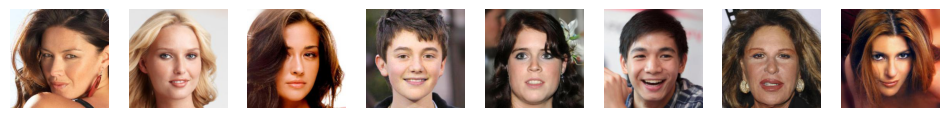

In [35]:
images, _ = next(iter(dataloader))
images = denormalize(images[:8], mean, std)

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
    axes[i].axis("off")
plt.show()

In [36]:
# Time embedding
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim * 4)
        self.linear2 = nn.Linear(dim * 4, dim)
        self.act = nn.SiLU()

    def forward(self, t):
        half_dim = self.linear1.in_features // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return self.linear2(self.act(self.linear1(emb)))

In [37]:
# Residual block with time embedding
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = self.block2(h)
        return h + self.residual(x)

In [38]:
# Self-Attention block (for 2D images)
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv1d(channels, channels, 1)
        self.k = nn.Conv1d(channels, channels, 1)
        self.v = nn.Conv1d(channels, channels, 1)
        self.proj = nn.Conv1d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_ = self.norm(x).view(B, C, H * W)  # [B, C, HW]
        q, k, v = self.q(x_), self.k(x_), self.v(x_)

        attn = torch.softmax(q.transpose(1, 2) @ k / math.sqrt(C), dim=-1)
        out = v @ attn.transpose(1, 2)  # [B, C, HW]
        out = self.proj(out).view(B, C, H, W)
        return out + x

In [39]:
# UNet with Conv down/up and center attention
class UNet(nn.Module):
    def __init__(self, time_emb_dim=256):
        super().__init__()
        self.time_embedding = TimeEmbedding(time_emb_dim)

        self.enc1 = ResBlock(32, 128, time_emb_dim)
        self.down1 = nn.Conv2d(128, 256, 4, 2, 1)  # downsample
        self.enc2 = ResBlock(256, 256, time_emb_dim)
        self.down2 = nn.Conv2d(256, 512, 4, 2, 1)  # downsample
        self.enc3 = ResBlock(512, 512, time_emb_dim)
        # self.down3 = nn.Conv2d(128, 256, 4, 2, 1)  # downsample
        # self.enc4 = ResBlock(256, 256, time_emb_dim)

        self.mid = nn.Sequential(
            ResBlock(512, 512, time_emb_dim),
            AttentionBlock(512),
            ResBlock(512, 512, time_emb_dim)
        )
        
        # self.up1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)  # upsample
        # self.dec1 = ResBlock(128, 128, time_emb_dim)
        self.up2 = nn.ConvTranspose2d(512, 256, 4, 2, 1)  # upsample
        self.dec2 = ResBlock(256, 256, time_emb_dim)
        self.up3 = nn.ConvTranspose2d(256, 128, 4, 2, 1)  # upsample
        self.dec3 = ResBlock(128, 128, time_emb_dim)
        self.out = nn.Conv2d(128, 32, 1)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)

        x1 = self.enc1(x, t_emb)
        x2 = self.enc2(self.down1(x1), t_emb)
        x3 = self.enc3(self.down2(x2), t_emb)
        # x4 = self.enc4(self.down3(x3), t_emb)        
        
        x_mid = self.mid[0](x3, t_emb)  # ResBlock
        x_mid = self.mid[1](x_mid)      # AttentionBlock
        x_mid = self.mid[2](x_mid, t_emb)  # ResBlock

        # x_up1 = self.dec1(self.up1(x_mid), t_emb)
        x_up2 = self.dec2(self.up2(x_mid), t_emb)
        x_up3 = self.dec3(self.up3(x_up2), t_emb)
        return self.out(x_up3)

In [40]:
from copy import deepcopy
# EMA Tracker
class EMA:
    def __init__(self, model, decay=0.9999):
        self.model = deepcopy(model)
        self.model.eval()
        self.decay = decay

    def update(self, model):
        with torch.no_grad():
            for p_ema, p in zip(self.model.parameters(), model.parameters()):
                p_ema.data.mul_(self.decay).add_(p.data, alpha=1 - self.decay)

In [41]:
# 创建 beta 调度器（线性或 cosine 可选）
def make_beta_schedule(schedule='linear', timesteps=1000, s=0.008):
    if schedule == 'linear':
        beta_start = 1e-4
        beta_end = 0.02
        return torch.linspace(beta_start, beta_end, timesteps)
    elif schedule == 'cosine':
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.9999)

In [42]:
# 扩散类
class Diffusion:
    def __init__(self, timesteps=1000, beta_schedule='cosine', device='cuda'):
        self.timesteps = timesteps
        self.betas = make_beta_schedule(beta_schedule, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)
        self.device = device

    # q(x_t | x_0)
    def q_sample(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        sqrt_alpha_hat = self.alpha_hat[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus = (1 - self.alpha_hat[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alpha_hat * x_0 + sqrt_one_minus * noise

    # 标准反向采样过程 p(x_{t-1} | x_t)
    def p_sample(self, model, x, t):
        beta_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = (1 - self.alpha_hat[t]).sqrt().view(-1, 1, 1, 1)
        alpha_t = self.alphas[t].view(-1, 1, 1, 1)

        eps_pred = model(x, t)
        mean = (1 / alpha_t.sqrt()) * (x - (beta_t / sqrt_one_minus_alpha) * eps_pred)
        noise = torch.randn_like(x) if (t > 0).all() else 0
        return mean + noise * beta_t.sqrt()

    # 完整采样流程
    def p_sample_loop(self, model, shape):
        x = torch.randn(shape).to(self.device)
        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((shape[0],), t, device=self.device, dtype=torch.long)
            x = self.p_sample(model, x, t_batch)
        return x

    # DDIM sampling（可调 eta）
    def ddim_sample(self, model, shape, eta=0.0, steps=50):
        times = torch.linspace(0, self.timesteps - 1, steps).long().to(self.device)
        alphas = self.alpha_hat[times]

        x = torch.randn(shape).to(self.device)

        for i in reversed(range(steps)):
            t = times[i].repeat(shape[0])
            alpha = alphas[i].view(-1, 1, 1, 1)
            eps = model(x, t)

            x0_pred = (x - eps * (1 - alpha).sqrt()) / alpha.sqrt()
            if i > 0:
                alpha_prev = alphas[i - 1].view(-1, 1, 1, 1)
                sigma = eta * ((1 - alpha_prev) / (1 - alpha) * (1 - alpha / alpha_prev)).sqrt()
                noise = torch.randn_like(x)
                x = alpha_prev.sqrt() * x0_pred + (1 - alpha_prev).sqrt() * eps + sigma * noise
            else:
                x = x0_pred
        return x

In [43]:
# 可视化保存路径
def save_samples(samples, step, path="./images/ldm_002_hq-face"):
    os.makedirs(path, exist_ok=True)
    save_image(samples, os.path.join(path, f"{step:04d}.png"), nrow=8, normalize=True)

In [44]:
class VAE(nn.Module):
    def __init__(self, in_channels=in_channels, latent_dim=latent_dim):  
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, latent_dim, kernel_size=3, stride=1, padding=1) 
        )

        self.conv_mu = nn.Conv2d(latent_dim, latent_dim, 1)
        self.conv_logvar = nn.Conv2d(latent_dim, latent_dim, 1)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, in_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )  
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.conv_mu(enc)
        logvar = self.conv_logvar(enc)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

In [45]:
model_vae=VAE().to(device)
model_vae.load_state_dict(torch.load('model_pkl/model_vae_02.pth'))
model_vae.eval()

C:\Users\sheng\AppData\Local\Temp\ipykernel_64760\1852388198.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vae.load_state_dict(torch.load('model_pkl/model_vae_02

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(512, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_mu): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv_logvar): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (decoder): Sequential(
    (

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 模型 & EMA
model = UNet().to(device)
ema = EMA(model, decay=0.99)
diffusion = Diffusion(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
epochs = 400
learning_rate = 1e-4
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [47]:
summary(model, input_size=[(32,32,32,32),(1,)])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [32, 32, 32, 32]          --
├─TimeEmbedding: 1-1                     [1, 256]                  --
│    └─Linear: 2-1                       [1, 1024]                 263,168
│    └─SiLU: 2-2                         [1, 1024]                 --
│    └─Linear: 2-3                       [1, 256]                  262,400
├─ResBlock: 1-2                          [32, 128, 32, 32]         --
│    └─Sequential: 2-4                   [32, 128, 32, 32]         --
│    │    └─Conv2d: 3-1                  [32, 128, 32, 32]         36,992
│    │    └─GroupNorm: 3-2               [32, 128, 32, 32]         256
│    │    └─SiLU: 3-3                    [32, 128, 32, 32]         --
│    └─Sequential: 2-5                   [1, 128]                  --
│    │    └─SiLU: 3-4                    [1, 256]                  --
│    │    └─Linear: 3-5                  [1, 128]                  32,

In [48]:
def save_checkpoint(model, ema, optimizer, epoch, loss, best_loss, path="./model_pkl/ldm_002.pth", best_path="./model_pkl/best_model_ldm_002.pth"):
    # 保存最新模型
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'ema_state_dict': ema.model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'best_loss': best_loss
    }, path)

    # 保存最优模型
    if loss < best_loss:
        print(f"[✓] Loss improved from {best_loss:.4f} to {loss:.4f}, saving best model.")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'ema_state_dict': ema.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'best_loss': loss
        }, best_path)
        return loss  # 更新 best_loss
    return best_loss

In [49]:
def load_checkpoint(model, ema, optimizer, path="./model_pkl/checkpoint.pth"):
    if not os.path.exists(path):
        print("[!] No checkpoint found.")
        return 0, float('inf')  # 从头开始训练

    checkpoint = torch.load(path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    ema.model.load_state_dict(checkpoint['ema_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"[✓] Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch'], checkpoint.get('best_loss', float('inf'))

In [50]:
best_loss = 1
for epoch in range(epochs):
    model.train()
    total_loss = 0
    pbar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch}")
    for i, (x, _) in enumerate(pbar):
        x = x.to(device)
        with torch.no_grad():
            x = model_vae.encoder(x)
        t = torch.randint(0, diffusion.timesteps, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = diffusion.q_sample(x, t, noise)

        loss = F.mse_loss(model(x_t, t), noise)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        ema.update(model)
        
        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    scheduler.step()  # 更新学习率
    avg_loss = total_loss / len(dataloader)
    print(f"[Epoch {epoch}] Loss: {avg_loss:.4f}")
    best_loss = save_checkpoint(model, ema, optimizer, epoch, avg_loss, best_loss)
    # 采样并保存
    if epoch % 5 == 0:
        with torch.no_grad():
            samples = diffusion.p_sample_loop(ema.model, (16, 32, 32, 32))
            samples = model_vae.decoder(samples)
            samples = samples.clamp(0, 1)
            samples = denormalize(samples, mean, std)
            save_samples(samples, epoch)

Epoch 0: 100%|███████████████████████████████████████████████████████████| 235/235 [03:03<00:00,  1.28it/s, loss=0.685]


[Epoch 0] Loss: 0.8691
[✓] Loss improved from 1.0000 to 0.8691, saving best model.


Epoch 1: 100%|███████████████████████████████████████████████████████████| 235/235 [01:56<00:00,  2.01it/s, loss=0.452]


[Epoch 1] Loss: 0.5417
[✓] Loss improved from 0.8691 to 0.5417, saving best model.


Epoch 2: 100%|████████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.33]


[Epoch 2] Loss: 0.3888
[✓] Loss improved from 0.5417 to 0.3888, saving best model.


Epoch 3: 100%|███████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.271]


[Epoch 3] Loss: 0.3136
[✓] Loss improved from 0.3888 to 0.3136, saving best model.


Epoch 4: 100%|███████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.01it/s, loss=0.227]


[Epoch 4] Loss: 0.2611
[✓] Loss improved from 0.3136 to 0.2611, saving best model.


Epoch 5: 100%|█████████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.2]


[Epoch 5] Loss: 0.2220
[✓] Loss improved from 0.2611 to 0.2220, saving best model.


Epoch 6: 100%|███████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.174]


[Epoch 6] Loss: 0.1924
[✓] Loss improved from 0.2220 to 0.1924, saving best model.


Epoch 7: 100%|████████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.18]


[Epoch 7] Loss: 0.1700
[✓] Loss improved from 0.1924 to 0.1700, saving best model.


Epoch 8: 100%|███████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.143]


[Epoch 8] Loss: 0.1557
[✓] Loss improved from 0.1700 to 0.1557, saving best model.


Epoch 9: 100%|████████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.15]


[Epoch 9] Loss: 0.1391
[✓] Loss improved from 0.1557 to 0.1391, saving best model.


Epoch 10: 100%|██████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.133]


[Epoch 10] Loss: 0.1346
[✓] Loss improved from 0.1391 to 0.1346, saving best model.


Epoch 11: 100%|██████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.123]


[Epoch 11] Loss: 0.1314
[✓] Loss improved from 0.1346 to 0.1314, saving best model.


Epoch 12: 100%|██████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.118]


[Epoch 12] Loss: 0.1305
[✓] Loss improved from 0.1314 to 0.1305, saving best model.


Epoch 13: 100%|███████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.12]


[Epoch 13] Loss: 0.1272
[✓] Loss improved from 0.1305 to 0.1272, saving best model.


Epoch 14: 100%|██████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.105]


[Epoch 14] Loss: 0.1169
[✓] Loss improved from 0.1272 to 0.1169, saving best model.


Epoch 15: 100%|██████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.265]


[Epoch 15] Loss: 0.1232


Epoch 16: 100%|███████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.13]


[Epoch 16] Loss: 0.1209


Epoch 17: 100%|██████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.102]


[Epoch 17] Loss: 0.1083
[✓] Loss improved from 0.1169 to 0.1083, saving best model.


Epoch 18: 100%|██████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.124]


[Epoch 18] Loss: 0.1046
[✓] Loss improved from 0.1083 to 0.1046, saving best model.


Epoch 19: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0902]


[Epoch 19] Loss: 0.1029
[✓] Loss improved from 0.1046 to 0.1029, saving best model.


Epoch 20: 100%|██████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.114]


[Epoch 20] Loss: 0.0996
[✓] Loss improved from 0.1029 to 0.0996, saving best model.


Epoch 21: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0857]


[Epoch 21] Loss: 0.0958
[✓] Loss improved from 0.0996 to 0.0958, saving best model.


Epoch 22: 100%|██████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.93it/s, loss=0.089]


[Epoch 22] Loss: 0.0937
[✓] Loss improved from 0.0958 to 0.0937, saving best model.


Epoch 23: 100%|██████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.104]


[Epoch 23] Loss: 0.0921
[✓] Loss improved from 0.0937 to 0.0921, saving best model.


Epoch 24: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0734]


[Epoch 24] Loss: 0.0882
[✓] Loss improved from 0.0921 to 0.0882, saving best model.


Epoch 25: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0704]


[Epoch 25] Loss: 0.0880
[✓] Loss improved from 0.0882 to 0.0880, saving best model.


Epoch 26: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0819]


[Epoch 26] Loss: 0.0870
[✓] Loss improved from 0.0880 to 0.0870, saving best model.


Epoch 27: 100%|██████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.107]


[Epoch 27] Loss: 0.0857
[✓] Loss improved from 0.0870 to 0.0857, saving best model.


Epoch 28: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0844]


[Epoch 28] Loss: 0.0858


Epoch 29: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0755]


[Epoch 29] Loss: 0.0837
[✓] Loss improved from 0.0857 to 0.0837, saving best model.


Epoch 30: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0945]


[Epoch 30] Loss: 0.0845


Epoch 31: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0703]


[Epoch 31] Loss: 0.0831
[✓] Loss improved from 0.0837 to 0.0831, saving best model.


Epoch 32: 100%|██████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.108]


[Epoch 32] Loss: 0.0827
[✓] Loss improved from 0.0831 to 0.0827, saving best model.


Epoch 33: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0671]


[Epoch 33] Loss: 0.0806
[✓] Loss improved from 0.0827 to 0.0806, saving best model.


Epoch 34: 100%|█████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.94it/s, loss=0.0653]


[Epoch 34] Loss: 0.0803
[✓] Loss improved from 0.0806 to 0.0803, saving best model.


Epoch 35: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0538]


[Epoch 35] Loss: 0.0787
[✓] Loss improved from 0.0803 to 0.0787, saving best model.


Epoch 36: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0623]


[Epoch 36] Loss: 0.0780
[✓] Loss improved from 0.0787 to 0.0780, saving best model.


Epoch 37: 100%|█████████████████████████████████████████████████████████| 235/235 [02:04<00:00,  1.89it/s, loss=0.0706]


[Epoch 37] Loss: 0.0777
[✓] Loss improved from 0.0780 to 0.0777, saving best model.


Epoch 38: 100%|█████████████████████████████████████████████████████████| 235/235 [02:05<00:00,  1.88it/s, loss=0.0961]


[Epoch 38] Loss: 0.0784


Epoch 39: 100%|██████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.087]


[Epoch 39] Loss: 0.0771
[✓] Loss improved from 0.0777 to 0.0771, saving best model.


Epoch 40: 100%|██████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.071]


[Epoch 40] Loss: 0.0766
[✓] Loss improved from 0.0771 to 0.0766, saving best model.


Epoch 41: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0688]


[Epoch 41] Loss: 0.0757
[✓] Loss improved from 0.0766 to 0.0757, saving best model.


Epoch 42: 100%|█████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.93it/s, loss=0.0649]


[Epoch 42] Loss: 0.0760


Epoch 43: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.94it/s, loss=0.0649]


[Epoch 43] Loss: 0.0766


Epoch 44: 100%|█████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.93it/s, loss=0.0814]


[Epoch 44] Loss: 0.0752
[✓] Loss improved from 0.0757 to 0.0752, saving best model.


Epoch 45: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0645]


[Epoch 45] Loss: 0.0752
[✓] Loss improved from 0.0752 to 0.0752, saving best model.


Epoch 46: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0803]


[Epoch 46] Loss: 0.0761


Epoch 47: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0676]


[Epoch 47] Loss: 0.0747
[✓] Loss improved from 0.0752 to 0.0747, saving best model.


Epoch 48: 100%|█████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0697]


[Epoch 48] Loss: 0.0726
[✓] Loss improved from 0.0747 to 0.0726, saving best model.


Epoch 49: 100%|██████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.066]


[Epoch 49] Loss: 0.0741


Epoch 50: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0784]


[Epoch 50] Loss: 0.0722
[✓] Loss improved from 0.0726 to 0.0722, saving best model.


Epoch 51: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0828]


[Epoch 51] Loss: 0.0716
[✓] Loss improved from 0.0722 to 0.0716, saving best model.


Epoch 52: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0822]


[Epoch 52] Loss: 0.0725


Epoch 53: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0776]


[Epoch 53] Loss: 0.0710
[✓] Loss improved from 0.0716 to 0.0710, saving best model.


Epoch 54: 100%|██████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.143]


[Epoch 54] Loss: 0.0740


Epoch 55: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0649]


[Epoch 55] Loss: 0.0763


Epoch 56: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0646]


[Epoch 56] Loss: 0.0670
[✓] Loss improved from 0.0710 to 0.0670, saving best model.


Epoch 57: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0728]


[Epoch 57] Loss: 0.0673


Epoch 58: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0571]


[Epoch 58] Loss: 0.0668
[✓] Loss improved from 0.0670 to 0.0668, saving best model.


Epoch 59: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0522]


[Epoch 59] Loss: 0.0653
[✓] Loss improved from 0.0668 to 0.0653, saving best model.


Epoch 60: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0543]


[Epoch 60] Loss: 0.0645
[✓] Loss improved from 0.0653 to 0.0645, saving best model.


Epoch 61: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0827]


[Epoch 61] Loss: 0.0642
[✓] Loss improved from 0.0645 to 0.0642, saving best model.


Epoch 62: 100%|█████████████████████████████████████████████████████████| 235/235 [02:55<00:00,  1.34it/s, loss=0.0657]


[Epoch 62] Loss: 0.0628
[✓] Loss improved from 0.0642 to 0.0628, saving best model.


Epoch 63: 100%|█████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.93it/s, loss=0.0718]


[Epoch 63] Loss: 0.0618
[✓] Loss improved from 0.0628 to 0.0618, saving best model.


Epoch 64: 100%|█████████████████████████████████████████████████████████| 235/235 [02:02<00:00,  1.92it/s, loss=0.0685]


[Epoch 64] Loss: 0.0628


Epoch 65: 100%|█████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.94it/s, loss=0.0524]


[Epoch 65] Loss: 0.0621


Epoch 66: 100%|█████████████████████████████████████████████████████████| 235/235 [02:03<00:00,  1.90it/s, loss=0.0487]


[Epoch 66] Loss: 0.0611
[✓] Loss improved from 0.0618 to 0.0611, saving best model.


Epoch 67: 100%|█████████████████████████████████████████████████████████| 235/235 [02:10<00:00,  1.81it/s, loss=0.0847]


[Epoch 67] Loss: 0.0616


Epoch 68: 100%|█████████████████████████████████████████████████████████| 235/235 [02:08<00:00,  1.84it/s, loss=0.0677]


[Epoch 68] Loss: 0.0616


Epoch 69: 100%|█████████████████████████████████████████████████████████| 235/235 [02:06<00:00,  1.85it/s, loss=0.0397]


[Epoch 69] Loss: 0.0608
[✓] Loss improved from 0.0611 to 0.0608, saving best model.


Epoch 70: 100%|█████████████████████████████████████████████████████████| 235/235 [02:10<00:00,  1.80it/s, loss=0.0483]


[Epoch 70] Loss: 0.0598
[✓] Loss improved from 0.0608 to 0.0598, saving best model.


Epoch 71: 100%|█████████████████████████████████████████████████████████| 235/235 [02:18<00:00,  1.69it/s, loss=0.0675]


[Epoch 71] Loss: 0.0590
[✓] Loss improved from 0.0598 to 0.0590, saving best model.


Epoch 72: 100%|█████████████████████████████████████████████████████████| 235/235 [02:10<00:00,  1.79it/s, loss=0.0534]


[Epoch 72] Loss: 0.0603


Epoch 73: 100%|█████████████████████████████████████████████████████████| 235/235 [02:12<00:00,  1.77it/s, loss=0.0577]


[Epoch 73] Loss: 0.0598


Epoch 74: 100%|█████████████████████████████████████████████████████████| 235/235 [02:10<00:00,  1.81it/s, loss=0.0566]


[Epoch 74] Loss: 0.0600


Epoch 75: 100%|█████████████████████████████████████████████████████████| 235/235 [02:06<00:00,  1.86it/s, loss=0.0473]


[Epoch 75] Loss: 0.0597


Epoch 76: 100%|█████████████████████████████████████████████████████████| 235/235 [02:06<00:00,  1.86it/s, loss=0.0712]


[Epoch 76] Loss: 0.0595


Epoch 77: 100%|█████████████████████████████████████████████████████████| 235/235 [02:06<00:00,  1.86it/s, loss=0.0808]


[Epoch 77] Loss: 0.0594


Epoch 78: 100%|█████████████████████████████████████████████████████████| 235/235 [02:06<00:00,  1.86it/s, loss=0.0403]


[Epoch 78] Loss: 0.0602


Epoch 79: 100%|█████████████████████████████████████████████████████████| 235/235 [02:08<00:00,  1.83it/s, loss=0.0595]


[Epoch 79] Loss: 0.0589
[✓] Loss improved from 0.0590 to 0.0589, saving best model.


Epoch 80: 100%|█████████████████████████████████████████████████████████| 235/235 [02:08<00:00,  1.84it/s, loss=0.0485]


[Epoch 80] Loss: 0.0581
[✓] Loss improved from 0.0589 to 0.0581, saving best model.


Epoch 81: 100%|█████████████████████████████████████████████████████████| 235/235 [02:15<00:00,  1.73it/s, loss=0.0736]


[Epoch 81] Loss: 0.0584


Epoch 82: 100%|██████████████████████████████████████████████████████████| 235/235 [02:12<00:00,  1.78it/s, loss=0.048]


[Epoch 82] Loss: 0.0587


Epoch 83: 100%|█████████████████████████████████████████████████████████| 235/235 [02:10<00:00,  1.79it/s, loss=0.0615]


[Epoch 83] Loss: 0.0589


Epoch 84: 100%|█████████████████████████████████████████████████████████| 235/235 [02:04<00:00,  1.89it/s, loss=0.0554]


[Epoch 84] Loss: 0.0583


Epoch 85: 100%|██████████████████████████████████████████████████████████| 235/235 [02:04<00:00,  1.88it/s, loss=0.057]


[Epoch 85] Loss: 0.0580
[✓] Loss improved from 0.0581 to 0.0580, saving best model.


Epoch 86: 100%|█████████████████████████████████████████████████████████| 235/235 [02:03<00:00,  1.90it/s, loss=0.0693]


[Epoch 86] Loss: 0.0583


Epoch 87: 100%|█████████████████████████████████████████████████████████| 235/235 [02:09<00:00,  1.82it/s, loss=0.0395]


[Epoch 87] Loss: 0.0576
[✓] Loss improved from 0.0580 to 0.0576, saving best model.


Epoch 88: 100%|██████████████████████████████████████████████████████████| 235/235 [02:08<00:00,  1.83it/s, loss=0.059]


[Epoch 88] Loss: 0.0573
[✓] Loss improved from 0.0576 to 0.0573, saving best model.


Epoch 89: 100%|█████████████████████████████████████████████████████████| 235/235 [02:07<00:00,  1.85it/s, loss=0.0504]


[Epoch 89] Loss: 0.0586


Epoch 90: 100%|█████████████████████████████████████████████████████████| 235/235 [02:11<00:00,  1.79it/s, loss=0.0421]


[Epoch 90] Loss: 0.0571
[✓] Loss improved from 0.0573 to 0.0571, saving best model.


Epoch 91: 100%|█████████████████████████████████████████████████████████| 235/235 [02:10<00:00,  1.80it/s, loss=0.0649]


[Epoch 91] Loss: 0.0569
[✓] Loss improved from 0.0571 to 0.0569, saving best model.


Epoch 92: 100%|█████████████████████████████████████████████████████████| 235/235 [02:09<00:00,  1.82it/s, loss=0.0377]


[Epoch 92] Loss: 0.0570


Epoch 93: 100%|█████████████████████████████████████████████████████████| 235/235 [02:05<00:00,  1.88it/s, loss=0.0496]


[Epoch 93] Loss: 0.0580


Epoch 94: 100%|█████████████████████████████████████████████████████████| 235/235 [02:07<00:00,  1.84it/s, loss=0.0578]


[Epoch 94] Loss: 0.0570


Epoch 95: 100%|█████████████████████████████████████████████████████████| 235/235 [02:08<00:00,  1.83it/s, loss=0.0707]


[Epoch 95] Loss: 0.0569
[✓] Loss improved from 0.0569 to 0.0569, saving best model.


Epoch 96: 100%|█████████████████████████████████████████████████████████| 235/235 [02:07<00:00,  1.85it/s, loss=0.0516]


[Epoch 96] Loss: 0.0571


Epoch 97: 100%|█████████████████████████████████████████████████████████| 235/235 [02:02<00:00,  1.91it/s, loss=0.0599]


[Epoch 97] Loss: 0.0568
[✓] Loss improved from 0.0569 to 0.0568, saving best model.


Epoch 98: 100%|█████████████████████████████████████████████████████████| 235/235 [02:21<00:00,  1.66it/s, loss=0.0392]


[Epoch 98] Loss: 0.0571


Epoch 99: 100%|█████████████████████████████████████████████████████████| 235/235 [02:52<00:00,  1.36it/s, loss=0.0397]


[Epoch 99] Loss: 0.0576


Epoch 100: 100%|█████████████████████████████████████████████████████████| 235/235 [02:27<00:00,  1.59it/s, loss=0.056]


[Epoch 100] Loss: 0.0569


Epoch 101: 100%|████████████████████████████████████████████████████████| 235/235 [02:06<00:00,  1.85it/s, loss=0.0544]


[Epoch 101] Loss: 0.0564
[✓] Loss improved from 0.0568 to 0.0564, saving best model.


Epoch 102: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0782]


[Epoch 102] Loss: 0.0579


Epoch 103: 100%|████████████████████████████████████████████████████████| 235/235 [02:05<00:00,  1.87it/s, loss=0.0536]


[Epoch 103] Loss: 0.0563
[✓] Loss improved from 0.0564 to 0.0563, saving best model.


Epoch 104: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0728]


[Epoch 104] Loss: 0.0568


Epoch 105: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0513]


[Epoch 105] Loss: 0.0555
[✓] Loss improved from 0.0563 to 0.0555, saving best model.


Epoch 106: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0497]


[Epoch 106] Loss: 0.0554
[✓] Loss improved from 0.0555 to 0.0554, saving best model.


Epoch 107: 100%|██████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.04]


[Epoch 107] Loss: 0.0552
[✓] Loss improved from 0.0554 to 0.0552, saving best model.


Epoch 108: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0341]


[Epoch 108] Loss: 0.0559


Epoch 109: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0518]


[Epoch 109] Loss: 0.0562


Epoch 110: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0586]


[Epoch 110] Loss: 0.0546
[✓] Loss improved from 0.0552 to 0.0546, saving best model.


Epoch 111: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0654]


[Epoch 111] Loss: 0.0552


Epoch 112: 100%|████████████████████████████████████████████████████████| 235/235 [02:06<00:00,  1.86it/s, loss=0.0734]


[Epoch 112] Loss: 0.0567


Epoch 113: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0503]


[Epoch 113] Loss: 0.0560


Epoch 114: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0644]


[Epoch 114] Loss: 0.0550


Epoch 115: 100%|█████████████████████████████████████████████████████████| 235/235 [02:03<00:00,  1.90it/s, loss=0.049]


[Epoch 115] Loss: 0.0564


Epoch 116: 100%|████████████████████████████████████████████████████████| 235/235 [02:07<00:00,  1.84it/s, loss=0.0501]


[Epoch 116] Loss: 0.0557


Epoch 117: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0499]


[Epoch 117] Loss: 0.0549


Epoch 118: 100%|████████████████████████████████████████████████████████| 235/235 [02:02<00:00,  1.92it/s, loss=0.0485]


[Epoch 118] Loss: 0.0551


Epoch 119: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0529]


[Epoch 119] Loss: 0.0551


Epoch 120: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0652]


[Epoch 120] Loss: 0.0551


Epoch 121: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0579]


[Epoch 121] Loss: 0.0557


Epoch 122: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0596]


[Epoch 122] Loss: 0.0555


Epoch 123: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0355]


[Epoch 123] Loss: 0.0546
[✓] Loss improved from 0.0546 to 0.0546, saving best model.


Epoch 124: 100%|█████████████████████████████████████████████████████████| 235/235 [02:02<00:00,  1.92it/s, loss=0.037]


[Epoch 124] Loss: 0.0541
[✓] Loss improved from 0.0546 to 0.0541, saving best model.


Epoch 125: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0896]


[Epoch 125] Loss: 0.0551


Epoch 126: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0575]


[Epoch 126] Loss: 0.0550


Epoch 127: 100%|█████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.93it/s, loss=0.061]


[Epoch 127] Loss: 0.0555


Epoch 128: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0589]


[Epoch 128] Loss: 0.0540
[✓] Loss improved from 0.0541 to 0.0540, saving best model.


Epoch 129: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0536]


[Epoch 129] Loss: 0.0542


Epoch 130: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0497]


[Epoch 130] Loss: 0.0551


Epoch 131: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0422]


[Epoch 131] Loss: 0.0547


Epoch 132: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.068]


[Epoch 132] Loss: 0.0544


Epoch 133: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0574]


[Epoch 133] Loss: 0.0542


Epoch 134: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0384]


[Epoch 134] Loss: 0.0543


Epoch 135: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0563]


[Epoch 135] Loss: 0.0545


Epoch 136: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0536]


[Epoch 136] Loss: 0.0546


Epoch 137: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0548]


[Epoch 137] Loss: 0.0540


Epoch 138: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0482]


[Epoch 138] Loss: 0.0538
[✓] Loss improved from 0.0540 to 0.0538, saving best model.


Epoch 139: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0567]


[Epoch 139] Loss: 0.0547


Epoch 140: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0492]


[Epoch 140] Loss: 0.0534
[✓] Loss improved from 0.0538 to 0.0534, saving best model.


Epoch 141: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0504]


[Epoch 141] Loss: 0.0526
[✓] Loss improved from 0.0534 to 0.0526, saving best model.


Epoch 142: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0465]


[Epoch 142] Loss: 0.0534


Epoch 143: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0551]


[Epoch 143] Loss: 0.0544


Epoch 144: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0345]


[Epoch 144] Loss: 0.0537


Epoch 145: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0449]


[Epoch 145] Loss: 0.0537


Epoch 146: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0859]


[Epoch 146] Loss: 0.0544


Epoch 147: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0629]


[Epoch 147] Loss: 0.0535


Epoch 148: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0437]


[Epoch 148] Loss: 0.0537


Epoch 149: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0702]


[Epoch 149] Loss: 0.0530


Epoch 150: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0361]


[Epoch 150] Loss: 0.0528


Epoch 151: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0525]


[Epoch 151] Loss: 0.0541


Epoch 152: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0472]


[Epoch 152] Loss: 0.0535


Epoch 153: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0548]


[Epoch 153] Loss: 0.0543


Epoch 154: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0609]


[Epoch 154] Loss: 0.0529


Epoch 155: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0649]


[Epoch 155] Loss: 0.0527


Epoch 156: 100%|██████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.05]


[Epoch 156] Loss: 0.0540


Epoch 157: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0392]


[Epoch 157] Loss: 0.0529


Epoch 158: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0463]


[Epoch 158] Loss: 0.0530


Epoch 159: 100%|████████████████████████████████████████████████████████| 235/235 [02:02<00:00,  1.92it/s, loss=0.0589]


[Epoch 159] Loss: 0.0525
[✓] Loss improved from 0.0526 to 0.0525, saving best model.


Epoch 160: 100%|████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.93it/s, loss=0.0521]


[Epoch 160] Loss: 0.0531


Epoch 161: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0452]


[Epoch 161] Loss: 0.0531


Epoch 162: 100%|████████████████████████████████████████████████████████| 235/235 [02:04<00:00,  1.89it/s, loss=0.0751]


[Epoch 162] Loss: 0.0530


Epoch 163: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0547]


[Epoch 163] Loss: 0.0539


Epoch 164: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0487]


[Epoch 164] Loss: 0.0531


Epoch 165: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0557]


[Epoch 165] Loss: 0.0531


Epoch 166: 100%|████████████████████████████████████████████████████████| 235/235 [02:04<00:00,  1.89it/s, loss=0.0357]


[Epoch 166] Loss: 0.0532


Epoch 167: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0609]


[Epoch 167] Loss: 0.0535


Epoch 168: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0673]


[Epoch 168] Loss: 0.0533


Epoch 169: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0741]


[Epoch 169] Loss: 0.0534


Epoch 170: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0393]


[Epoch 170] Loss: 0.0522
[✓] Loss improved from 0.0525 to 0.0522, saving best model.


Epoch 171: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0541]


[Epoch 171] Loss: 0.0528


Epoch 172: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0557]


[Epoch 172] Loss: 0.0526


Epoch 173: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0428]


[Epoch 173] Loss: 0.0524


Epoch 174: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0548]


[Epoch 174] Loss: 0.0520
[✓] Loss improved from 0.0522 to 0.0520, saving best model.


Epoch 175: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0747]


[Epoch 175] Loss: 0.0533


Epoch 176: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0404]


[Epoch 176] Loss: 0.0524


Epoch 177: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0482]


[Epoch 177] Loss: 0.0523


Epoch 178: 100%|████████████████████████████████████████████████████████| 235/235 [02:03<00:00,  1.91it/s, loss=0.0636]


[Epoch 178] Loss: 0.0526


Epoch 179: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0455]


[Epoch 179] Loss: 0.0524


Epoch 180: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0356]


[Epoch 180] Loss: 0.0518
[✓] Loss improved from 0.0520 to 0.0518, saving best model.


Epoch 181: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.069]


[Epoch 181] Loss: 0.0526


Epoch 182: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0557]


[Epoch 182] Loss: 0.0525


Epoch 183: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0742]


[Epoch 183] Loss: 0.0516
[✓] Loss improved from 0.0518 to 0.0516, saving best model.


Epoch 184: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0435]


[Epoch 184] Loss: 0.0518


Epoch 185: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0529]


[Epoch 185] Loss: 0.0526


Epoch 186: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0638]


[Epoch 186] Loss: 0.0515
[✓] Loss improved from 0.0516 to 0.0515, saving best model.


Epoch 187: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0488]


[Epoch 187] Loss: 0.0528


Epoch 188: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0424]


[Epoch 188] Loss: 0.0530


Epoch 189: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.033]


[Epoch 189] Loss: 0.0518


Epoch 190: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0475]


[Epoch 190] Loss: 0.0519


Epoch 191: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0454]


[Epoch 191] Loss: 0.0514
[✓] Loss improved from 0.0515 to 0.0514, saving best model.


Epoch 192: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0574]


[Epoch 192] Loss: 0.0523


Epoch 193: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0388]


[Epoch 193] Loss: 0.0519


Epoch 194: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0759]


[Epoch 194] Loss: 0.0520


Epoch 195: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0404]


[Epoch 195] Loss: 0.0525


Epoch 196: 100%|█████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.041]


[Epoch 196] Loss: 0.0514


Epoch 197: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0485]


[Epoch 197] Loss: 0.0524


Epoch 198: 100%|████████████████████████████████████████████████████████| 235/235 [02:04<00:00,  1.89it/s, loss=0.0708]


[Epoch 198] Loss: 0.0520


Epoch 199: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0381]


[Epoch 199] Loss: 0.0505
[✓] Loss improved from 0.0514 to 0.0505, saving best model.


Epoch 200: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0709]


[Epoch 200] Loss: 0.0513


Epoch 201: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0744]


[Epoch 201] Loss: 0.0522


Epoch 202: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0443]


[Epoch 202] Loss: 0.0516


Epoch 203: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0582]


[Epoch 203] Loss: 0.0513


Epoch 204: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0728]


[Epoch 204] Loss: 0.0517


Epoch 205: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0591]


[Epoch 205] Loss: 0.0515


Epoch 206: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0511]


[Epoch 206] Loss: 0.0521


Epoch 207: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0484]


[Epoch 207] Loss: 0.0517


Epoch 208: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0954]


[Epoch 208] Loss: 0.0516


Epoch 209: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0441]


[Epoch 209] Loss: 0.0514


Epoch 210: 100%|██████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.04]


[Epoch 210] Loss: 0.0518


Epoch 211: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0587]


[Epoch 211] Loss: 0.0506


Epoch 212: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.99it/s, loss=0.0459]


[Epoch 212] Loss: 0.0507


Epoch 213: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0484]


[Epoch 213] Loss: 0.0503
[✓] Loss improved from 0.0505 to 0.0503, saving best model.


Epoch 214: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0524]


[Epoch 214] Loss: 0.0520


Epoch 215: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.074]


[Epoch 215] Loss: 0.0522


Epoch 216: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.049]


[Epoch 216] Loss: 0.0510


Epoch 217: 100%|█████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.048]


[Epoch 217] Loss: 0.0517


Epoch 218: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0723]


[Epoch 218] Loss: 0.0516


Epoch 219: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.047]


[Epoch 219] Loss: 0.0510


Epoch 220: 100%|████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.94it/s, loss=0.0478]


[Epoch 220] Loss: 0.0517


Epoch 221: 100%|████████████████████████████████████████████████████████| 235/235 [02:03<00:00,  1.90it/s, loss=0.0417]


[Epoch 221] Loss: 0.0508


Epoch 222: 100%|████████████████████████████████████████████████████████| 235/235 [02:03<00:00,  1.90it/s, loss=0.0511]


[Epoch 222] Loss: 0.0511


Epoch 223: 100%|████████████████████████████████████████████████████████| 235/235 [02:07<00:00,  1.85it/s, loss=0.0593]


[Epoch 223] Loss: 0.0505


Epoch 224: 100%|████████████████████████████████████████████████████████| 235/235 [02:02<00:00,  1.92it/s, loss=0.0384]


[Epoch 224] Loss: 0.0509


Epoch 225: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0438]


[Epoch 225] Loss: 0.0505


Epoch 226: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.0428]


[Epoch 226] Loss: 0.0502
[✓] Loss improved from 0.0503 to 0.0502, saving best model.


Epoch 227: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  1.99it/s, loss=0.029]


[Epoch 227] Loss: 0.0516


Epoch 228: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.01it/s, loss=0.045]


[Epoch 228] Loss: 0.0513


Epoch 229: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0449]


[Epoch 229] Loss: 0.0512


Epoch 230: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0452]


[Epoch 230] Loss: 0.0505


Epoch 231: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.01it/s, loss=0.0767]


[Epoch 231] Loss: 0.0508


Epoch 232: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0512]


[Epoch 232] Loss: 0.0510


Epoch 233: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0522]


[Epoch 233] Loss: 0.0515


Epoch 234: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0359]


[Epoch 234] Loss: 0.0506


Epoch 235: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0497]


[Epoch 235] Loss: 0.0514


Epoch 236: 100%|█████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.01it/s, loss=0.076]


[Epoch 236] Loss: 0.0510


Epoch 237: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0478]


[Epoch 237] Loss: 0.0505


Epoch 238: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0533]


[Epoch 238] Loss: 0.0509


Epoch 239: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0362]


[Epoch 239] Loss: 0.0510


Epoch 240: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0507]


[Epoch 240] Loss: 0.0515


Epoch 241: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0546]


[Epoch 241] Loss: 0.0510


Epoch 242: 100%|████████████████████████████████████████████████████████| 235/235 [01:57<00:00,  2.00it/s, loss=0.0532]


[Epoch 242] Loss: 0.0515


Epoch 243: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0485]


[Epoch 243] Loss: 0.0504


Epoch 244: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0619]


[Epoch 244] Loss: 0.0510


Epoch 245: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0675]


[Epoch 245] Loss: 0.0510


Epoch 246: 100%|█████████████████████████████████████████████████████████| 235/235 [03:48<00:00,  1.03it/s, loss=0.051]


[Epoch 246] Loss: 0.0509


Epoch 247: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0527]


[Epoch 247] Loss: 0.0502
[✓] Loss improved from 0.0502 to 0.0502, saving best model.


Epoch 248: 100%|█████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.068]


[Epoch 248] Loss: 0.0508


Epoch 249: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0623]


[Epoch 249] Loss: 0.0503


Epoch 250: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0483]


[Epoch 250] Loss: 0.0513


Epoch 251: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0614]


[Epoch 251] Loss: 0.0510


Epoch 252: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0593]


[Epoch 252] Loss: 0.0499
[✓] Loss improved from 0.0502 to 0.0499, saving best model.


Epoch 253: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0425]


[Epoch 253] Loss: 0.0496
[✓] Loss improved from 0.0499 to 0.0496, saving best model.


Epoch 254: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0446]


[Epoch 254] Loss: 0.0502


Epoch 255: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0392]


[Epoch 255] Loss: 0.0504


Epoch 256: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0334]


[Epoch 256] Loss: 0.0493
[✓] Loss improved from 0.0496 to 0.0493, saving best model.


Epoch 257: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0361]


[Epoch 257] Loss: 0.0509


Epoch 258: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0475]


[Epoch 258] Loss: 0.0501


Epoch 259: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0536]


[Epoch 259] Loss: 0.0499


Epoch 260: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0937]


[Epoch 260] Loss: 0.0510


Epoch 261: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0334]


[Epoch 261] Loss: 0.0504


Epoch 262: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0782]


[Epoch 262] Loss: 0.0507


Epoch 263: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0555]


[Epoch 263] Loss: 0.0494


Epoch 264: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0534]


[Epoch 264] Loss: 0.0502


Epoch 265: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0624]


[Epoch 265] Loss: 0.0499


Epoch 266: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0511]


[Epoch 266] Loss: 0.0495


Epoch 267: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0508]


[Epoch 267] Loss: 0.0502


Epoch 268: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0405]


[Epoch 268] Loss: 0.0499


Epoch 269: 100%|██████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.05]


[Epoch 269] Loss: 0.0497


Epoch 270: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0399]


[Epoch 270] Loss: 0.0502


Epoch 271: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0341]


[Epoch 271] Loss: 0.0498


Epoch 272: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0517]


[Epoch 272] Loss: 0.0503


Epoch 273: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0452]


[Epoch 273] Loss: 0.0501


Epoch 274: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0458]


[Epoch 274] Loss: 0.0508


Epoch 275: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0329]


[Epoch 275] Loss: 0.0498


Epoch 276: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0401]


[Epoch 276] Loss: 0.0502


Epoch 277: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0456]


[Epoch 277] Loss: 0.0497


Epoch 278: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0523]


[Epoch 278] Loss: 0.0497


Epoch 279: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0438]


[Epoch 279] Loss: 0.0493


Epoch 280: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0562]


[Epoch 280] Loss: 0.0498


Epoch 281: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0604]


[Epoch 281] Loss: 0.0501


Epoch 282: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0578]


[Epoch 282] Loss: 0.0512


Epoch 283: 100%|████████████████████████████████████████████████████████| 235/235 [02:03<00:00,  1.90it/s, loss=0.0457]


[Epoch 283] Loss: 0.0496


Epoch 284: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0496]


[Epoch 284] Loss: 0.0500


Epoch 285: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0466]


[Epoch 285] Loss: 0.0495


Epoch 286: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0587]


[Epoch 286] Loss: 0.0503


Epoch 287: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0589]


[Epoch 287] Loss: 0.0497


Epoch 288: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0504]


[Epoch 288] Loss: 0.0494


Epoch 289: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0438]


[Epoch 289] Loss: 0.0502


Epoch 290: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0415]


[Epoch 290] Loss: 0.0495


Epoch 291: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0732]


[Epoch 291] Loss: 0.0501


Epoch 292: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0458]


[Epoch 292] Loss: 0.0500


Epoch 293: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0619]


[Epoch 293] Loss: 0.0498


Epoch 294: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0515]


[Epoch 294] Loss: 0.0505


Epoch 295: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0631]


[Epoch 295] Loss: 0.0495


Epoch 296: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0488]


[Epoch 296] Loss: 0.0492
[✓] Loss improved from 0.0493 to 0.0492, saving best model.


Epoch 297: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0704]


[Epoch 297] Loss: 0.0490
[✓] Loss improved from 0.0492 to 0.0490, saving best model.


Epoch 298: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0422]


[Epoch 298] Loss: 0.0491


Epoch 299: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0407]


[Epoch 299] Loss: 0.0501


Epoch 300: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0492]


[Epoch 300] Loss: 0.0500


Epoch 301: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0742]


[Epoch 301] Loss: 0.0502


Epoch 302: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0365]


[Epoch 302] Loss: 0.0504


Epoch 303: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0389]


[Epoch 303] Loss: 0.0489
[✓] Loss improved from 0.0490 to 0.0489, saving best model.


Epoch 304: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0589]


[Epoch 304] Loss: 0.0496


Epoch 305: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0545]


[Epoch 305] Loss: 0.0499


Epoch 306: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0504]


[Epoch 306] Loss: 0.0496


Epoch 307: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0385]


[Epoch 307] Loss: 0.0486
[✓] Loss improved from 0.0489 to 0.0486, saving best model.


Epoch 308: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0689]


[Epoch 308] Loss: 0.0497


Epoch 309: 100%|█████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.042]


[Epoch 309] Loss: 0.0494


Epoch 310: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0689]


[Epoch 310] Loss: 0.0488


Epoch 311: 100%|█████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.039]


[Epoch 311] Loss: 0.0493


Epoch 312: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0647]


[Epoch 312] Loss: 0.0499


Epoch 313: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0409]


[Epoch 313] Loss: 0.0489


Epoch 314: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0453]


[Epoch 314] Loss: 0.0485
[✓] Loss improved from 0.0486 to 0.0485, saving best model.


Epoch 315: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0395]


[Epoch 315] Loss: 0.0489


Epoch 316: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0571]


[Epoch 316] Loss: 0.0492


Epoch 317: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0497]


[Epoch 317] Loss: 0.0488


Epoch 318: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0594]


[Epoch 318] Loss: 0.0495


Epoch 319: 100%|██████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.07]


[Epoch 319] Loss: 0.0491


Epoch 320: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0708]


[Epoch 320] Loss: 0.0495


Epoch 321: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0375]


[Epoch 321] Loss: 0.0480
[✓] Loss improved from 0.0485 to 0.0480, saving best model.


Epoch 322: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0509]


[Epoch 322] Loss: 0.0486


Epoch 323: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0701]


[Epoch 323] Loss: 0.0493


Epoch 324: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0598]


[Epoch 324] Loss: 0.0499


Epoch 325: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0486]


[Epoch 325] Loss: 0.0487


Epoch 326: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0513]


[Epoch 326] Loss: 0.0489


Epoch 327: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0424]


[Epoch 327] Loss: 0.0492


Epoch 328: 100%|████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.93it/s, loss=0.0384]


[Epoch 328] Loss: 0.0488


Epoch 329: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0374]


[Epoch 329] Loss: 0.0503


Epoch 330: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0538]


[Epoch 330] Loss: 0.0495


Epoch 331: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0604]


[Epoch 331] Loss: 0.0490


Epoch 332: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0655]


[Epoch 332] Loss: 0.0497


Epoch 333: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0472]


[Epoch 333] Loss: 0.0498


Epoch 334: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0422]


[Epoch 334] Loss: 0.0495


Epoch 335: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0396]


[Epoch 335] Loss: 0.0491


Epoch 336: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0927]


[Epoch 336] Loss: 0.0487


Epoch 337: 100%|█████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.056]


[Epoch 337] Loss: 0.0490


Epoch 338: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0337]


[Epoch 338] Loss: 0.0485


Epoch 339: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0365]


[Epoch 339] Loss: 0.0485


Epoch 340: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0456]


[Epoch 340] Loss: 0.0491


Epoch 341: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0368]


[Epoch 341] Loss: 0.0502


Epoch 342: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0492]


[Epoch 342] Loss: 0.0490


Epoch 343: 100%|█████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.077]


[Epoch 343] Loss: 0.0495


Epoch 344: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0705]


[Epoch 344] Loss: 0.0491


Epoch 345: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0411]


[Epoch 345] Loss: 0.0495


Epoch 346: 100%|████████████████████████████████████████████████████████| 235/235 [01:58<00:00,  1.98it/s, loss=0.0413]


[Epoch 346] Loss: 0.0485


Epoch 347: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0423]


[Epoch 347] Loss: 0.0494


Epoch 348: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0753]


[Epoch 348] Loss: 0.0495


Epoch 349: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0511]


[Epoch 349] Loss: 0.0494


Epoch 350: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0404]


[Epoch 350] Loss: 0.0497


Epoch 351: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0557]


[Epoch 351] Loss: 0.0487


Epoch 352: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0823]


[Epoch 352] Loss: 0.0490


Epoch 353: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0637]


[Epoch 353] Loss: 0.0500


Epoch 354: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0603]


[Epoch 354] Loss: 0.0489


Epoch 355: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0432]


[Epoch 355] Loss: 0.0486


Epoch 356: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0397]


[Epoch 356] Loss: 0.0484


Epoch 357: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0487]


[Epoch 357] Loss: 0.0488


Epoch 358: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0518]


[Epoch 358] Loss: 0.0489


Epoch 359: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0439]


[Epoch 359] Loss: 0.0488


Epoch 360: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0547]


[Epoch 360] Loss: 0.0487


Epoch 361: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0434]


[Epoch 361] Loss: 0.0486


Epoch 362: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0457]


[Epoch 362] Loss: 0.0491


Epoch 363: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0415]


[Epoch 363] Loss: 0.0494


Epoch 364: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0755]


[Epoch 364] Loss: 0.0493


Epoch 365: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0721]


[Epoch 365] Loss: 0.0493


Epoch 366: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0606]


[Epoch 366] Loss: 0.0488


Epoch 367: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.97it/s, loss=0.0469]


[Epoch 367] Loss: 0.0493


Epoch 368: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.045]


[Epoch 368] Loss: 0.0488


Epoch 369: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0563]


[Epoch 369] Loss: 0.0481


Epoch 370: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0473]


[Epoch 370] Loss: 0.0494


Epoch 371: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0366]


[Epoch 371] Loss: 0.0488


Epoch 372: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0775]


[Epoch 372] Loss: 0.0489


Epoch 373: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.041]


[Epoch 373] Loss: 0.0492


Epoch 374: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.037]


[Epoch 374] Loss: 0.0488


Epoch 375: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0323]


[Epoch 375] Loss: 0.0485


Epoch 376: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0346]


[Epoch 376] Loss: 0.0491


Epoch 377: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0652]


[Epoch 377] Loss: 0.0491


Epoch 378: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0454]


[Epoch 378] Loss: 0.0492


Epoch 379: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0444]


[Epoch 379] Loss: 0.0484


Epoch 380: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0497]


[Epoch 380] Loss: 0.0485


Epoch 381: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0538]


[Epoch 381] Loss: 0.0484


Epoch 382: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0548]


[Epoch 382] Loss: 0.0490


Epoch 383: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.0409]


[Epoch 383] Loss: 0.0481


Epoch 384: 100%|████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.94it/s, loss=0.0418]


[Epoch 384] Loss: 0.0481


Epoch 385: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0696]


[Epoch 385] Loss: 0.0491


Epoch 386: 100%|████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.94it/s, loss=0.0618]


[Epoch 386] Loss: 0.0489


Epoch 387: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0424]


[Epoch 387] Loss: 0.0492


Epoch 388: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0345]


[Epoch 388] Loss: 0.0492


Epoch 389: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0528]


[Epoch 389] Loss: 0.0489


Epoch 390: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0375]


[Epoch 390] Loss: 0.0495


Epoch 391: 100%|████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.0455]


[Epoch 391] Loss: 0.0486


Epoch 392: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.96it/s, loss=0.051]


[Epoch 392] Loss: 0.0490


Epoch 393: 100%|█████████████████████████████████████████████████████████| 235/235 [02:00<00:00,  1.95it/s, loss=0.066]


[Epoch 393] Loss: 0.0488


Epoch 394: 100%|████████████████████████████████████████████████████████| 235/235 [02:07<00:00,  1.84it/s, loss=0.0538]


[Epoch 394] Loss: 0.0492


Epoch 395: 100%|█████████████████████████████████████████████████████████| 235/235 [02:04<00:00,  1.89it/s, loss=0.066]


[Epoch 395] Loss: 0.0489


Epoch 396: 100%|████████████████████████████████████████████████████████| 235/235 [01:59<00:00,  1.96it/s, loss=0.0588]


[Epoch 396] Loss: 0.0485


Epoch 397: 100%|████████████████████████████████████████████████████████| 235/235 [02:04<00:00,  1.89it/s, loss=0.0395]


[Epoch 397] Loss: 0.0489


Epoch 398: 100%|█████████████████████████████████████████████████████████| 235/235 [02:03<00:00,  1.90it/s, loss=0.045]


[Epoch 398] Loss: 0.0489


Epoch 399: 100%|████████████████████████████████████████████████████████| 235/235 [02:01<00:00,  1.94it/s, loss=0.0618]


[Epoch 399] Loss: 0.0489


In [92]:
# 保存多个中间步骤图像
def visualize_denoising(diffusion, model, shape, save_dir="./images", steps=10):
    os.makedirs(save_dir, exist_ok=True)
    x = torch.randn(shape).to(diffusion.device)
    indices = torch.linspace(0, diffusion.timesteps - 1, steps).long()

    with torch.no_grad():
        for i, t in enumerate(reversed(indices)):
            t_batch = torch.full((shape[0],), t.item(), dtype=torch.long).to(diffusion.device)
            x = diffusion.p_sample(model, x, t_batch)
            out = (x.clamp(-1, 1) + 1) / 2
            save_image(out, os.path.join(save_dir, f"step_{i:02d}.png"), nrow=8)